### Probate records data noodling
Data set from Gloria Main, emerita U Colorado:
http://eh.net/database/new-england-1631-1776-sample-of-18509-probates/

Code by Shane Landrum, <srl@cliotropic.org>


In [162]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


data_file = 'Main-Main-New-Eng-probates-2013.xlsx'
                       
# get the main data set. This is the big table.
def probate_records():
    pr = pd.read_excel( data_file,
                        sheetname='main data set', 
                        header=0,
                        skiprows=4, 
                        skip_footer=19,
                        index_col=0, 
                        parse_cols='A:C,M:T')  # basic year and life cycle information
    return pr.fillna('')

# map colonies to colony numbers.
def colonies():
    c = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0,
                      skiprows=4,
                      skip_footer=270,
                      parse_cols="A,B,C")
    return c.fillna('')

# map counties to county numbers.
def counties():
    c = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0,
                      skiprows=15,
                      skip_footer=251,
                      parse_cols="A,B,C")
    return c.fillna('')

# map towns to town codes.
def towns():
    t = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0, 
                      skiprows=4,
                      skip_footer=2,
                      parse_cols="M:Q")
    return t.fillna('')

# map occupations to occupation codes.
def occupations():
    t = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0, 
                      skiprows=33,
                      skip_footer=236,
                      parse_cols="A,B")
    return t.fillna('')

def lifestages():
    t = pd.read_excel(data_file,
                      sheetname='Some code values',
                      header=0,
                      index_col=0, 
                      skiprows=53,
                      skip_footer=219,
                      parse_cols="A,C")
    return t.fillna('')
 

def bigtable():
    # This will take some time because the data file is 6.5MB.
    
    # merge tables to bring in colony names.
    bt = probate_records().merge(colonies(), how="left", left_on="colony", right_index=True)
    # Move textual names for colonies into the 'colony' column, drop the badly-labeled 'This is' column
    bt['colony'] = bt['This is']
    bt = bt.drop(['This is'], 1)
    bt = bt.drop(['Sample n ='], 1) # Not sure why this is getting added, but make it go away

    
    # merge tables to bring in county names.
    bt = bt.merge(counties(), how="left", left_on="county", right_index=True)
    # Move textual names for counties into the 'county' column, drop the badly-labeled 'This is' column
    bt['county'] = bt['This is']
    bt = bt.drop(['This is'], 1)

    # merge tables to bring in occupation names.
    bt = bt.merge(occupations(), how="left", left_on="xocc", right_index=True)
    # Move textual names for occupations into the 'xocc' column, drop the badly-labeled 'This is' column
    bt['xocc'] = bt['This is']
    bt = bt.drop(['This is'], 1)

    # merge tables to bring in life cycle stages.
    bt = bt.merge(lifestages(), how="left", left_on="newlc", right_index=True)
    # Move textual names for life stages into the 'newlc' column, drop the badly-labeled 'This is' column
    bt['newlc'] = bt['This is']
    bt = bt.drop(['This is'], 1)

    
    # merge tables to bring in town names. 
    townlabels = towns()["This town is"].to_frame()
    bt = bt.merge(townlabels, how="left", left_on="town", right_index=True)
    # Move textual names for towns into the 'town' column, drop the badly-labeled 'This town is' column
    bt['town'] = bt['This town is']
    bt = bt.drop(['This town is'], 1)
    bt = bt.drop(['sample n ='], 1) # Not sure why this is getting added, but make it go away
    
    return(bt)

# Ages at death graphic

This shows a basically random distribution of deaths across years, with some years when deaths were more common.
For example, something in the mid-1670s happened to kill a lot of younger men. I'm guessing it was the Pequot
War. 

I haven't researched historically to see whether those deaths correlate with wars or epidemics, or 
whether they're just an artifact of the sampling method that brought us this data set. 

<IPython.core.display.Javascript object>


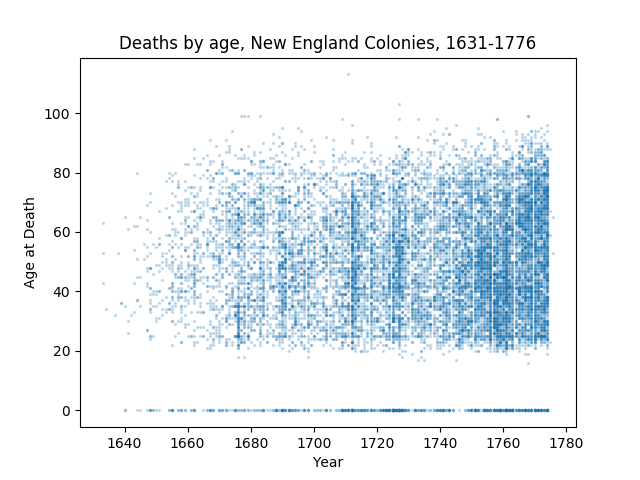

In [174]:
def ages_at_death():
    pr = pd.read_excel( data_file,
                        sheetname='main data set', 
                        header=0,
                        skiprows=4, 
                        skip_footer=19,
                        index_col=0, 
                        parse_cols='A:C')  # basic year and life cycle information
    
    return pr 

def plot_deaths(d):
    
    fig, ax = plt.subplots()
    
    # can't just do this, because pandas datetime starts in 1677: 
    #   http://pandas-docs.github.io/pandas-docs-travis/timeseries.html#timestamp-limitations
    #year = pd.to_datetime(d['year'], format="%Y")
    
    year = d['year'].astype('int32')
    
    # we should deal with the empty age fields somehow, right now just passing them in as 0.
    age = d['age']
    
    # scatterplot of age and year of death
    ax.scatter(year, age, s=2, alpha=0.2  )


    # x and y axis labeling and such    
    ax.set_ylabel('Age at Death')
    ax.set_xlabel('Year')
    ax.set_title('Deaths by age, New England Colonies, 1631-1776')


death_ages = ages_at_death().dropna(axis=0, how="any")
plot_deaths(death_ages)

# Visualizing ages and life stages at death

This code sets up functions for several different graphs below.
I'm interested in whether there are noticeable patterns in life stages
and age at death.

<IPython.core.display.Javascript object>


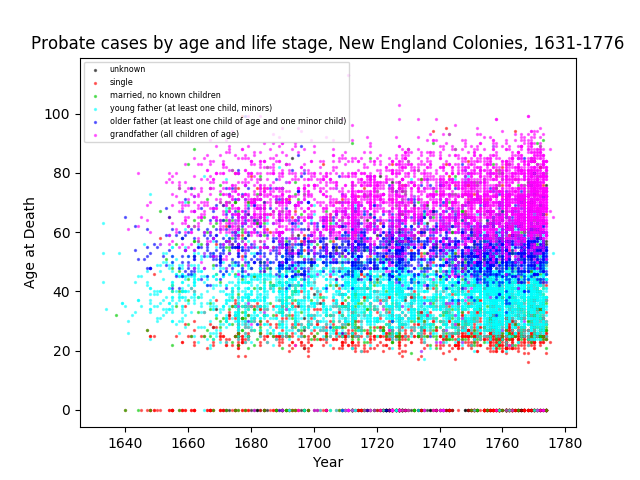

In [168]:
def ages_and_stages_at_death():
    pr = pd.read_excel( data_file,
                        sheetname='main data set', 
                        header=0,
                        skiprows=4, 
                        skip_footer=19,
                        index_col=0, 
                        parse_cols='A:C, R, T')  # basic year, life cycle stage, and colony information
    
    
    # merge tables to bring in life stages.
    pr = pr.merge(lifestages(), how="left", left_on="newlc", right_index=True)
    # Move textual names for occupations into the 'life stage' column, drop the badly-labeled 'This is' column
    pr['life stage'] = pr['This is']
    pr = pr.drop(['This is'], 1)



    # merge tables to bring in colony names.
    pr = pr.merge(colonies(), how="left", left_on="colony", right_index=True)
    # Move textual names for colonies into the 'colony' column, drop the badly-labeled 'This is' column
    pr['colony'] = pr['This is']
    pr = pr.drop(['This is'], 1)
    pr = pr.drop(['Sample n ='], 1) # Not sure why this is getting added, but make it go away    
    # remove people with NaNs (mostly for age)
    pr.dropna(axis=0, how="any", inplace=True)

    return pr 


def plot_deaths_by_stages(da, header):
    
    fig, ax = plt.subplots()
    
    colors = ['#000000', '#ff0000', '#00cc00', '#00ffff', '#0000ff', '#ff00ff']
    ci = 0
    for s in lifestages().values[0:6]:
        stage = s[0]
        
        # get all the rows for this life stage
        d = da.loc[da['life stage'] == stage]
                
        year = d['year'].astype('int32')
    
        # TODO: we should deal with the empty age fields somehow, right now just passing them in as 0.
        age = d['age']
 
        # scatterplot of age and year of death, colored by life stage
        ax.scatter(year, age, s=2, c=colors[ci], alpha=0.5, label=stage  )
    
        ci = ci+1
        
    # legend for the colors
    ax.legend(loc=2, fontsize='xx-small')

    # x and y axis labeling and such    
    ax.set_ylabel('Age at Death')
    ax.set_xlabel('Year')
    ax.set_title(header)


death_ages = ages_and_stages_at_death()
plot_deaths_by_stages(death_ages, 'Probate cases by age and life stage, New England Colonies, 1631-1776')

# Probate cases by age and life stage, Boston, 1631-1776

This shows us more nuance about the data set. There's a big gap in the Boston data set,
roughly 1700-1765, perhaps because a fire burned the original records?


<IPython.core.display.Javascript object>


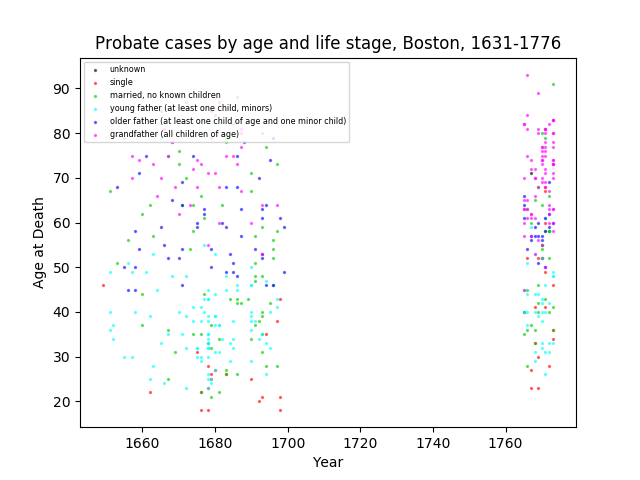

In [169]:
da_boston = death_ages.loc[death_ages['colony'] == 'Boston']
plot_deaths_by_stages(da_boston, 'Probate cases by age and life stage, Boston, 1631-1776')


# Probate cases by age and life stage, Connecticut, 1631-1776

The Connecticut data doesn't seem to have any major time gaps. 

<IPython.core.display.Javascript object>


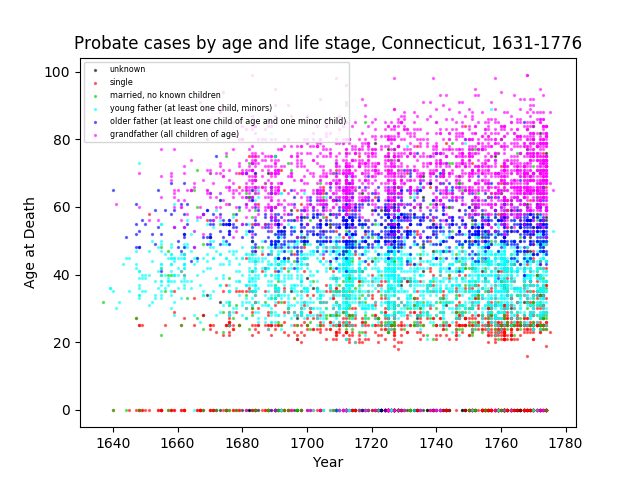

In [170]:
da_ct = death_ages.loc[death_ages['colony'] == 'Connecticut']
plot_deaths_by_stages(da_ct, 'Probate cases by age and life stage, Connecticut, 1631-1776')

# Value of probated estates by occupation, Connecticut, 1631-1776



<IPython.core.display.Javascript object>


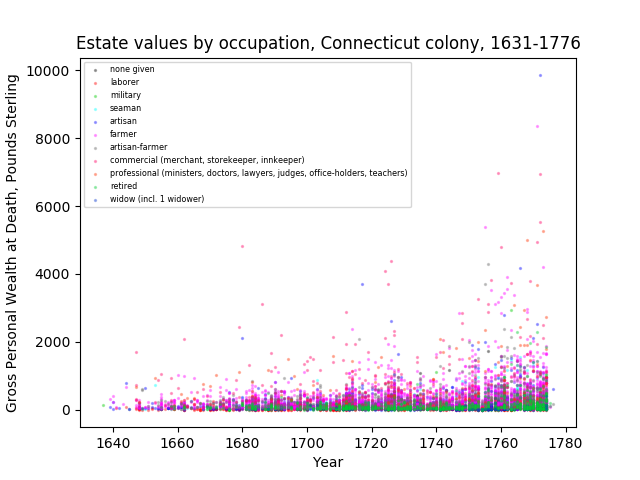

In [171]:
def estates_and_occupations_at_death():
    pr = pd.read_excel( data_file,
                        sheetname='main data set', 
                        header=0,
                        skiprows=4, 
                        skip_footer=19,
                        index_col=0, 
                        parse_cols='A:C, P, T, AE')  # basic year, xocc (occupation), colony, total wealth sterling
    
    
    # merge tables to bring in occupation names.
    pr = pr.merge(occupations(), how="left", left_on="xocc", right_index=True)
    # Move textual names for occupations into the 'xocc' column, drop the badly-labeled 'This is' column
    pr['xocc'] = pr['This is']
    pr = pr.drop(['This is'], 1)


    # merge tables to bring in colony names.
    pr = pr.merge(colonies(), how="left", left_on="colony", right_index=True)
    # Move textual names for colonies into the 'colony' column, drop the badly-labeled 'This is' column
    pr['colony'] = pr['This is']
    pr = pr.drop(['This is'], 1)
    pr = pr.drop(['Sample n ='], 1) # Not sure why this is getting added, but make it go away    
    # remove people with NaNs (mostly for age)
    pr.dropna(axis=0, how="any", inplace=True)

    return pr 

def plot_estates_by_occupation (da, header):
    
    fig, ax = plt.subplots()
    
    colors = ['#000000', '#ff0000', '#00cc00', '#00ffff', '#0000ff', '#ff00ff', 
              '#666666', '#ff0066', '#ff3300', '#00cc33', '#0033cc', '#ffcccc']
    #np.random.seed(19680801)
    #colors = np.random.rand(15)
    
    ci = 0
    for o in occupations().values[0:11]:
        occ = o[0]
        
        # get all the rows for this life stage
        d = da.loc[da['xocc'] == occ]
                
        year = d['year'].astype('int32')
    
        wealth = d['dtotal']

        color = colors[ci]

        # scatterplot of age and estate value, colored by occupation
        ax.scatter(year, wealth, s=2, c=color, alpha=0.3, label=occ  )
    
        ci = ci+1
        
    # legend for the colors
    ax.legend(loc=2, fontsize='xx-small')

    # x and y axis labeling and such    
    ax.set_ylabel('Gross Personal Wealth at Death, Pounds Sterling')
    ax.set_xlabel('Year')
    ax.set_title(header)


estates = estates_and_occupations_at_death()
est_ct = estates.loc[estates['colony'] == 'Connecticut']
plot_estates_by_occupation(est_ct, 'Estate values by occupation, Connecticut colony, 1631-1776')

<IPython.core.display.Javascript object>


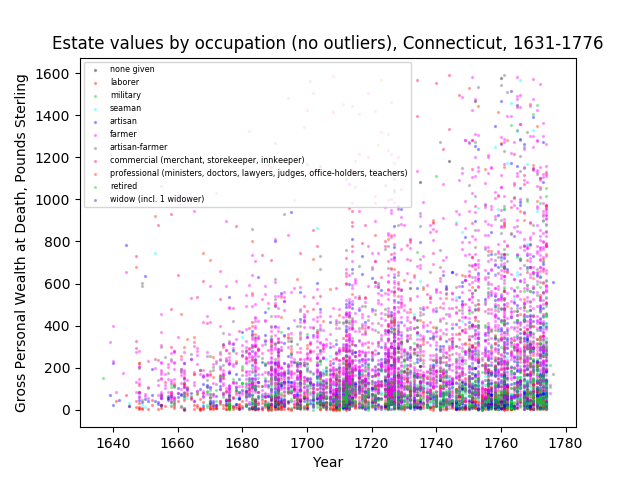

In [172]:
est_ct = estates.loc[estates['colony'] == 'Connecticut']

#keep only the wealth values that are within +3 to -3 standard deviations in the column 'dtotal'.
# source: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe
est_ct_without_outliers = est_ct[np.abs( est_ct.dtotal-est_ct.dtotal.mean()) <= (3*est_ct.dtotal.std() )] 

plot_estates_by_occupation(est_ct_without_outliers, 'Estate values by occupation (no outliers), Connecticut, 1631-1776')

<IPython.core.display.Javascript object>


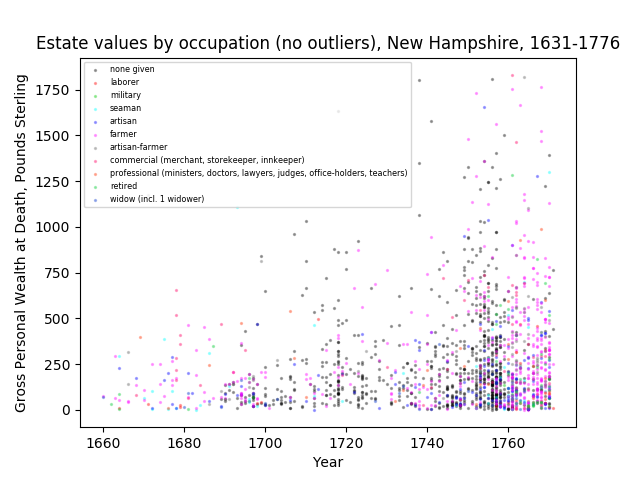

In [173]:
est_nh = estates.loc[estates['colony'] == 'New Hampshire']

#keep only the wealth values that are within +3 to -3 standard deviations in the column 'dtotal'.
# source: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe
est_nh_without_outliers = est_nh[np.abs( est_nh.dtotal-est_nh.dtotal.mean()) <= (3*est_nh.dtotal.std() )] 

plot_estates_by_occupation(est_nh_without_outliers, 
                           'Estate values by occupation (no outliers), New Hampshire, 1631-1776')